In [1]:
!pip install transformers==4.29.0 torch scikit-learn tqdm datasets

                                                text     V     A     D
0        Remember what she said in my last letter? "  3.00  3.00  3.20
1                          If I wasn't working here.  2.80  3.10  2.80
2                                                .."  3.00  3.00  3.00
3  Goodwill helps people get off of public assist...  3.44  3.00  3.22
4  Sherry learned through our Future Works class ...  3.55  3.27  3.46


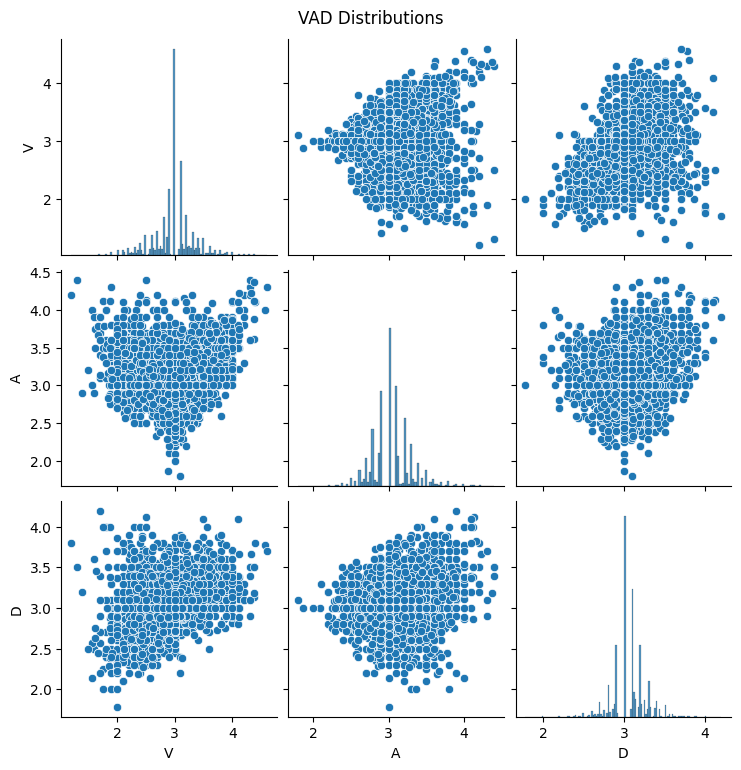

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#check out https://github.com/JULIELab/EmoBank for more info about the data
df = pd.read_csv("emobank.csv")

print(df[['text', 'V', 'A', 'D']].head())

sns.pairplot(df[['V', 'A', 'D']])
plt.suptitle("VAD Distributions", y=1.02)
plt.show()

In [2]:
from sklearn.model_selection import train_test_split

df = df[['text', 'V', 'A', 'D']]

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

In [3]:
print(len(train_df))
train_df.dropna(axis=0,inplace=True)
print(len(train_df))

9055
9054


In [7]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset
import torch
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

class VADDataset(Dataset):
    def __init__(self, df):
        self.encodings = tokenizer(df["text"].tolist(), truncation=True, padding=True, max_length=128)
        self.labels = df[['V', 'A', 'D']].values.astype(np.float32)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float32)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = VADDataset(train_df)
test_dataset = VADDataset(test_df)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", problem_type="regression", num_labels=3)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the check

In [9]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/vad_regression",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="/content/drive/MyDrive/vad_regression/logs",
    logging_strategy="epoch",
    report_to="tensorboard",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

model.save_pretrained("/content/drive/MyDrive/vad_regression/vad-bert")
tokenizer.save_pretrained("/content/drive/MyDrive/vad_regression/vad-bert")

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.031900,0.050263
2,0.023800,0.049893
3,0.019800,0.051710
4,0.016700,0.049348
5,0.013000,0.050014


('/content/drive/MyDrive/vad_regression/vad-bert/tokenizer_config.json',
 '/content/drive/MyDrive/vad_regression/vad-bert/special_tokens_map.json',
 '/content/drive/MyDrive/vad_regression/vad-bert/vocab.txt',
 '/content/drive/MyDrive/vad_regression/vad-bert/added_tokens.json',
 '/content/drive/MyDrive/vad_regression/vad-bert/tokenizer.json')

In [11]:
from huggingface_hub import notebook_login

notebook_login()

In [12]:
model.push_to_hub("RobroKools/vad-bert")
tokenizer.push_to_hub("RobroKools/vad-bert")

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/RobroKools/vad-bert/commit/80013b271ae94beffe7462ae644c59b8dff65f37', commit_message='Upload tokenizer', commit_description='', oid='80013b271ae94beffe7462ae644c59b8dff65f37', pr_url=None, repo_url=RepoUrl('https://huggingface.co/RobroKools/vad-bert', endpoint='https://huggingface.co', repo_type='model', repo_id='RobroKools/vad-bert'), pr_revision=None, pr_num=None)